In [ ]:
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

In [ ]:
!tar -xzvf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()
results_file = './write/pmbc3k.h5ad'

scanpy==1.2.2 anndata==0.6.5 numpy==1.14.5 scipy==1.1.0 pandas==0.23.2 scikit-learn==0.19.1 statsmodels==0.9.0 


In [3]:
path = './filtered_gene_bc_matrices/hg19/'
adata = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]

... reading from cache file ./cache/filtered_gene_bc_matrices-hg19-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata.var_names_make_unique()

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

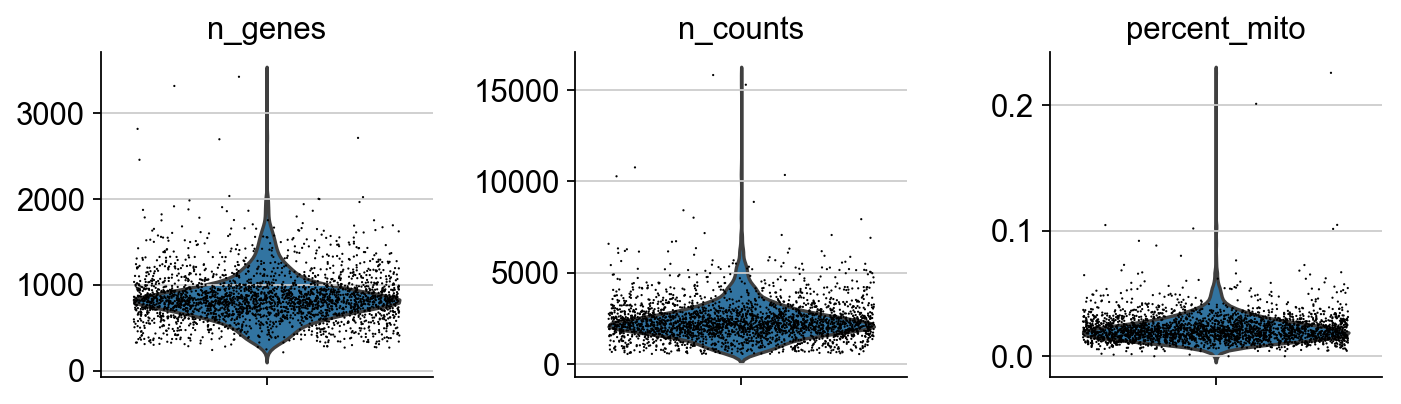

In [7]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

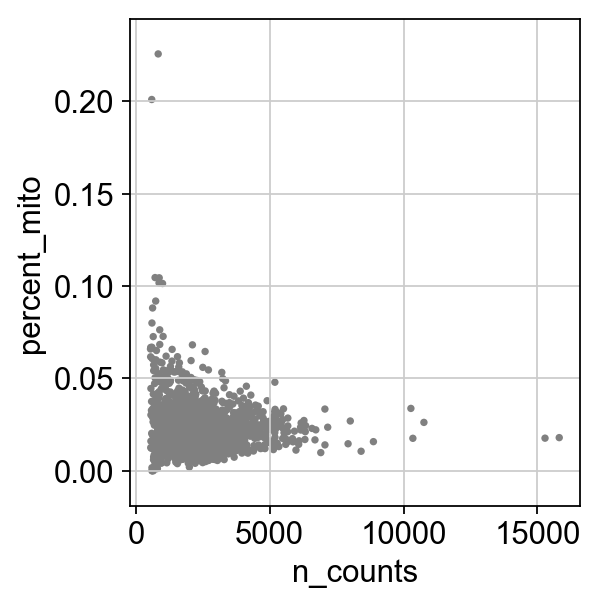

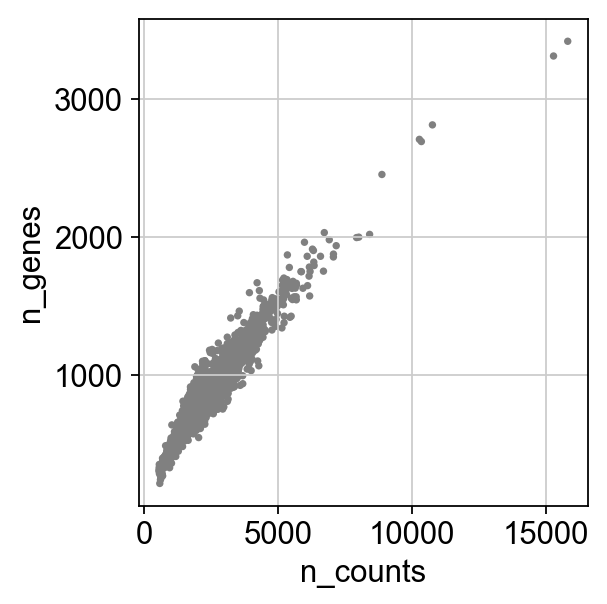

In [8]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [9]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [10]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

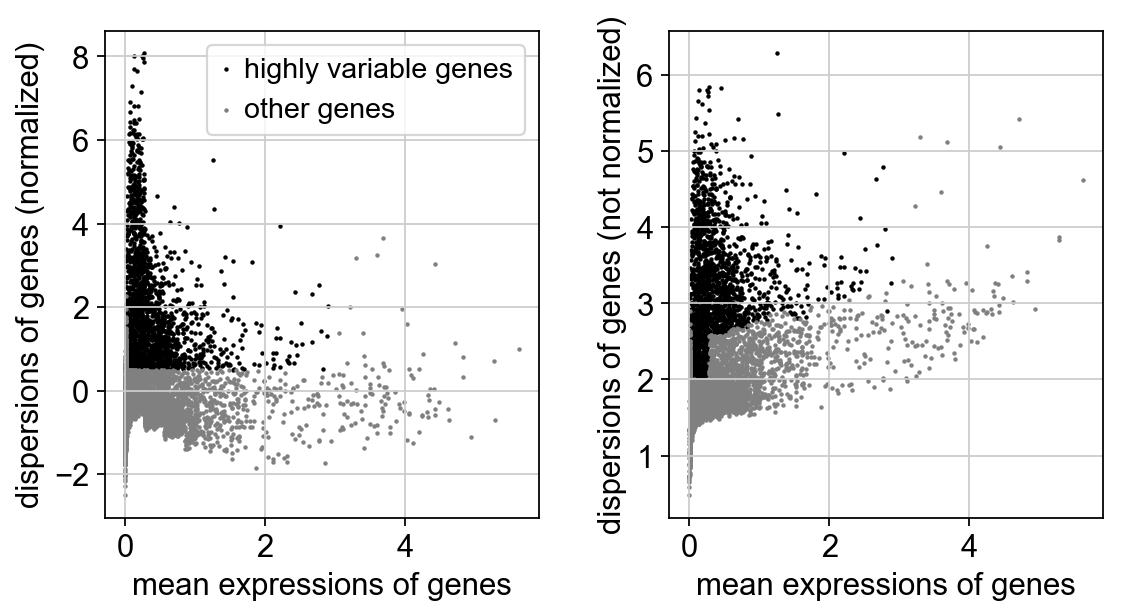

In [12]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [13]:
adata = adata[:, filter_result.gene_subset]

In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:04.64)


In [16]:
sc.pp.scale(adata, max_value=10)

In [17]:
adata.write(results_file)

In [18]:
sc.tl.pca(adata)

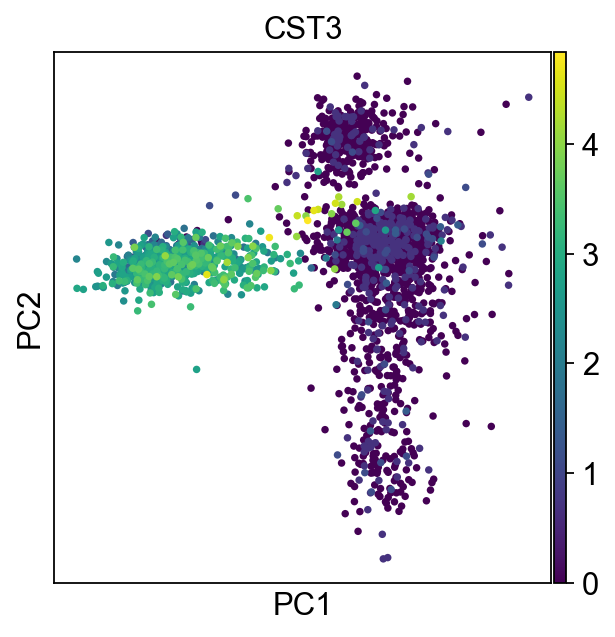

In [19]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata, color='CST3')

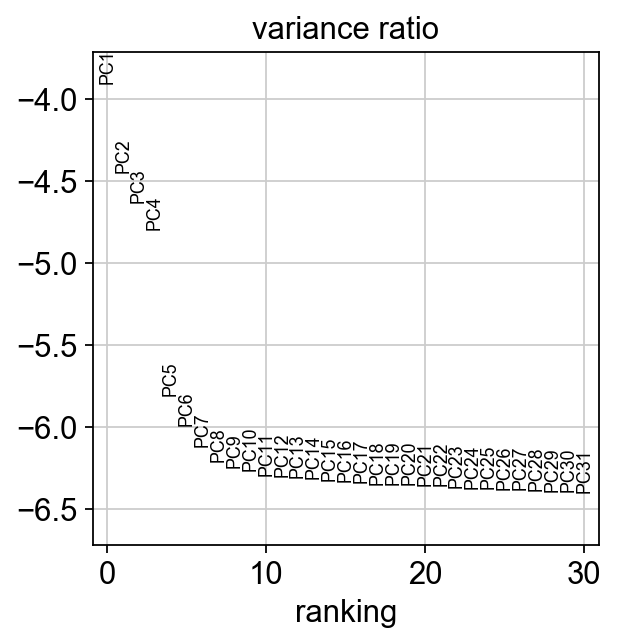

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
adata.write(results_file)

In [22]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
adata = sc.read(results_file)

In [25]:
sc.tl.tsne(adata, random_state=2, n_pcs=10)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.07) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


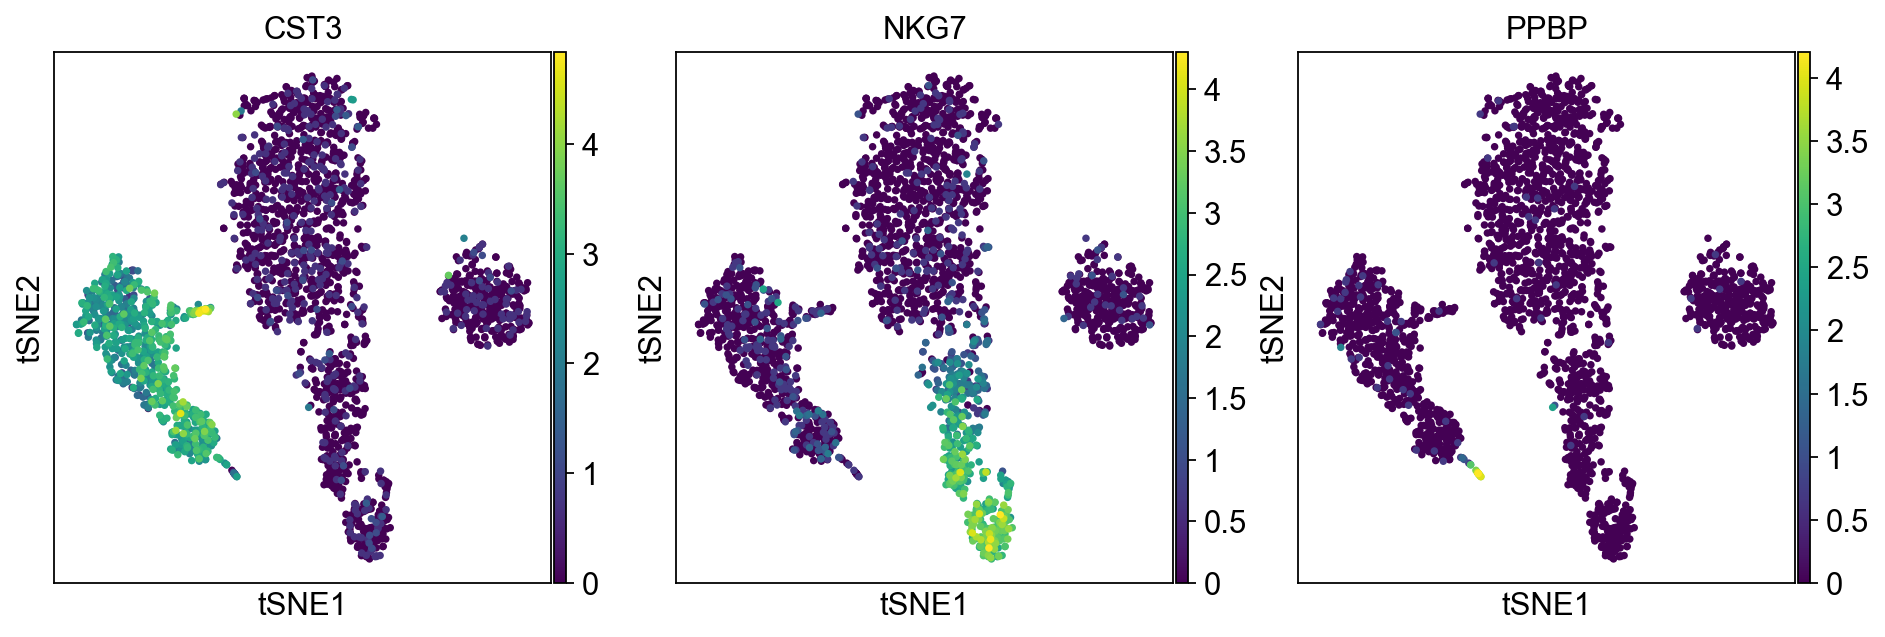

In [26]:
sc.pl.tsne(adata, color=['CST3', 'NKG7', 'PPBP'])